In [1]:
import re
import json

In [3]:
with open('Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21246

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
4         2981319        21246               30   
11        2905904        21246               30   
260       1128466        21246              208   
10857     2862432        21246             8228   
11325     2748003        21246             8228   

                                                   title  year  \
4      Unified phase variables of relative degree two...  2016   
11     A unified parameterization of human gait acros...  2016   
260    Cooperative n-boundary tracking in large scale...  2012   
10857  Privacy aware distributed computing of control...  2016   
11325  Consensus with bounded controls for a class of...  2015   

                                                abstract  
4      A starting point to achieve stable locomotion ...  
11     This paper introduces a novel gait parameteriz...  
260    Monitoring in large scale environments is a ty...  
10857  In the coming era of smart grids, the merging ...  
11325  This paper considers the consensus problem syn...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

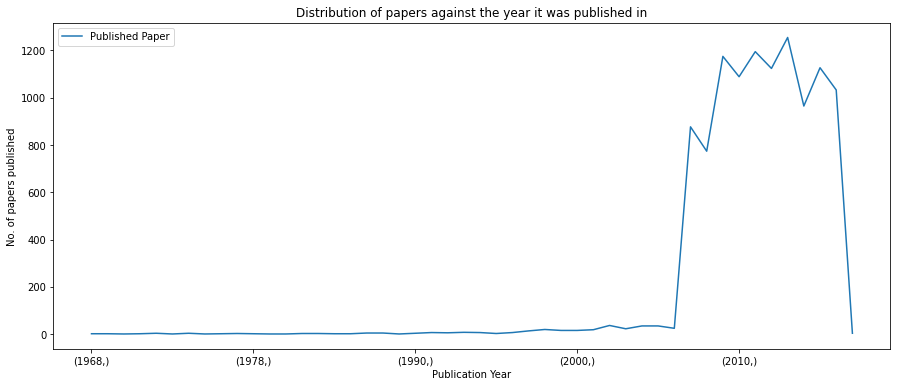

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2008 with year 2013 accounting for the highest number of papers.

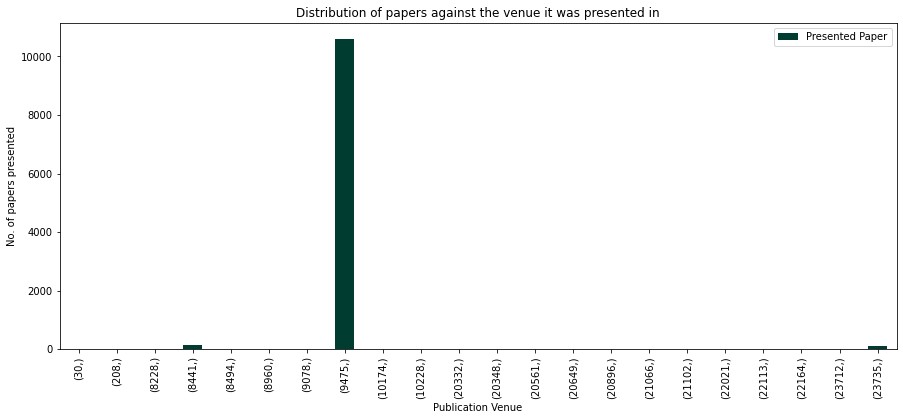

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [13]:
conference_data_dict[9475]

'conference on decision and control'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 9475 which corresponds to the **Conference on Decision and Control**, Hence most of the papers in the community are from that conference. We should be expecting papers about decision making and controlling from the papers of this community.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

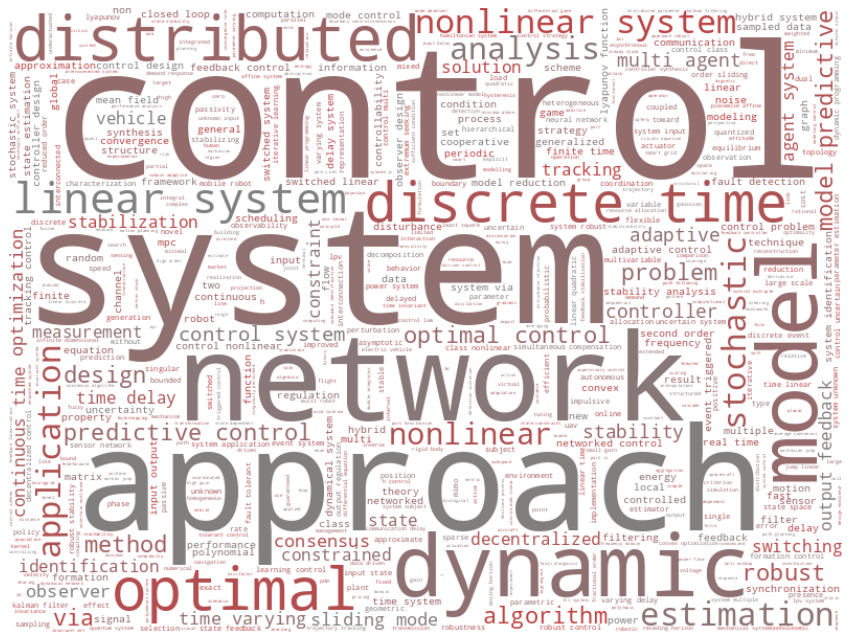

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on dsitributed control systems and approaches. Since most papers of the community were presented at a conference about decision and control, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

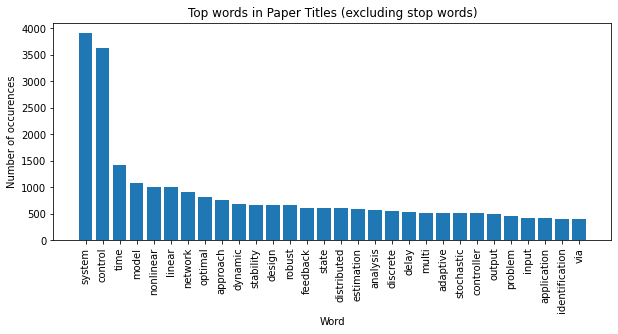

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are system, control,time, model and so on. Considering most papers are about remote sensing and geo spatial data, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.053*"control" + 0.032*"system" + 0.032*"feedback" + 0.028*"design" + 0.026*"controller" + 0.017*"formation"'),
 (1,
  '0.038*"control" + 0.024*"optimal" + 0.016*"system" + 0.014*"energy" + 0.014*"large" + 0.014*"stochastic"'),
 (2,
  '0.062*"system" + 0.025*"control" + 0.022*"model" + 0.018*"linear" + 0.018*"synchronization" + 0.018*"output"'),
 (3,
  '0.046*"system" + 0.029*"stability" + 0.021*"analysis" + 0.018*"control" + 0.016*"linear" + 0.015*"differential"'),
 (4,
  '0.069*"control" + 0.023*"vehicle" + 0.022*"robot" + 0.017*"model" + 0.014*"robust" + 0.014*"power"'),
 (5,
  '0.068*"system" + 0.058*"time" + 0.027*"delay" + 0.025*"linear" + 0.025*"multi" + 0.021*"agent"'),
 (6,
  '0.062*"system" + 0.024*"control" + 0.024*"nonlinear" + 0.019*"estimation" + 0.017*"fault" + 0.017*"input"'),
 (7,
  '0.089*"control" + 0.031*"system" + 0.028*"model" + 0.021*"predictive" + 0.016*"nonlinear" + 0.016*"mode"'),
 (8,
  '0.045*"system" + 0.040*"control" + 0.020*"design" + 0.017*"nonl

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

control    system  feedback    design  controller  formation    output  \
0  0.052575  0.032065  0.031519  0.028027    0.025578   0.017143  0.015651   
1  0.038202  0.016323  0.000000  0.000000    0.000000   0.000000  0.000000   
2  0.025412  0.062109  0.017057  0.008006    0.009564   0.000000  0.017639   
3  0.017555  0.046198  0.000000  0.000000    0.000000   0.000000  0.000000   
4  0.069071  0.009107  0.000000  0.000000    0.000000   0.000000  0.000000   
5  0.010118  0.068063  0.000000  0.000000    0.000000   0.000000  0.000000   
6  0.023875  0.062166  0.000000  0.000000    0.000000   0.000000  0.009523   
7  0.089200  0.030717  0.000000  0.000000    0.006544   0.000000  0.000000   
8  0.040012  0.044949  0.000000  0.019605    0.007082   0.000000  0.000000   
9  0.049538  0.022871  0.000000  0.000000    0.000000   0.000000  0.000000   

    optimal    linear   dynamic  ...       two  information  controllability  \
0  0.014072  0.010937  0.010617  ...  0.000000     0.000000         0.000000   
1  0.024009  0.000000  0.000000  ...  0.000000     0.000000         0.000000   
2  0.009332  0.018477  0.012552  ...  0.000000     0.000000         0.000000   
3  0.000000  0.016175  0.007399  ...  0.000000     0.000000         0.000000   
4  0.009518  0.000000  0.000000  ...  0.000000     0.000000         0.000000   
5  0.000000  0.024738  0.000000  ...  0.000000     0.000000         0.000000   
6  0.000000  0.010793  0.000000  ...  0.000000     0.000000         0.000000   
7  0.000000  0.000000  0.000000  ...  0.000000     0.000000         0.000000   
8  0.016585  0.000000  0.009587  ...  0.000000     0.000000         0.000000   
9  0.015946  0.008832  0.010315  ...  0.009561     0.009138         0.007892   

      event  approximate  probabilistic  hierarchical  boundary      flow  \
0  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
1  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
2  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
3  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
4  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
5  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
6  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
7  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
8  0.000000     0.000000       0.000000      0.000000  0.000000  0.000000   
9  0.007626     0.006872       0.006299      0.005888  0.005698  0.005671   

     neural  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
7  0.000000  
8  0.000000  
9  0.005537  

[10 rows x 135 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


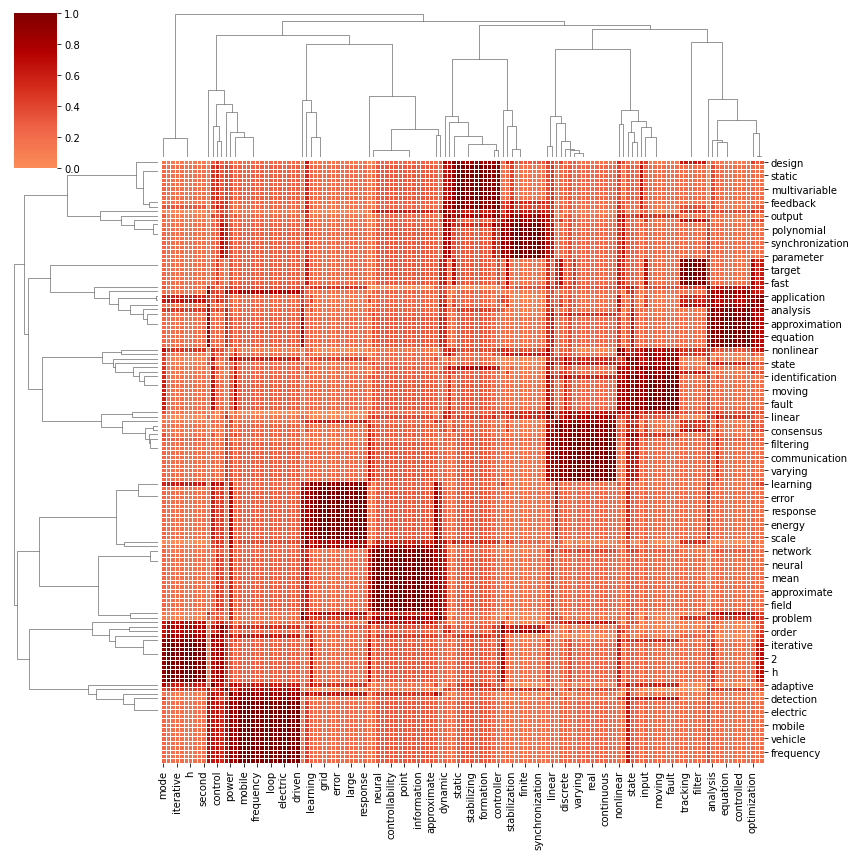

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  15.815154
7       0.648955  71.707100       2        1  12.600070
6      71.019684   9.971006       3        1  11.913310
9       3.785981  33.185135       4        1  11.083186
0     -42.666500  -9.222070       5        1  10.972750
4      -3.621689 -43.526516       6        1  10.422391
5      -3.632402  -4.171708       7        1   9.874268
8     -36.584400  35.804413       8        1   6.621139
2      44.391380  50.615383       9        1   5.363431
3      40.235809 -31.591665      10        1   5.334302, topic_info=          Term        Freq       Total Category  logprob  loglift
37      system  397.000000  397.000000  Default  30.0000  30.0000
111       time  132.000000  132.000000  Default  29.0000  29.0000
23     control  487.000000  487.000000  Default  28.0000  28.0000
43     network  109.000000  109.000000  Default  27.0000  27.0000
175   feedback   70.000000   70.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
43     network    5.234555  109.590289  Topic10  -4.7145  -0.1105
84   algorithm    4.662857   53.902642  Topic10  -4.8302   0.4835
853   switched    4.002214   23.920467  Topic10  -4.9830   1.1431
170    dynamic    4.320809   72.371392  Topic10  -4.9064   0.1126
156      model    3.944194  127.181207  Topic10  -4.9976  -0.5424

[752 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
420       9  0.633189             '
741       1  0.761668            's
741       2  0.228500            's
1343      2  0.675980             1
1343      9  0.270392             1
...     ...       ...           ...
646       5  1.033114          wing
2090      9  1.091323  witsenhausen
670       3  0.624008         world
2514      6  1.142440           yaw
2159      2  0.993007          zone

[1441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 7, 10, 1, 5, 6, 9, 3, 4])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  agent, control, multi, formation, consensus, attitude, leader, path, network, planning, rigid, heterogeneous, directed, system, motion

Paper Titles:
Cooperative global robust output regulation for nonlinear multi-agent systems in output feedback form with directed switching networks
Trajectory tracking of mechanical systems with unilateral constraints: Experimental results of a recently introduced hybrid PD feedback controller
Parameter convergence via a novel PI-like composite adaptive controller for uncertain Euler-Lagrange systems
A model predictive control scheme for consensus in multi-agent systems with single-integrator dynamics and input constraints

****************************************************************************************************
TOPIC 1:
Top Words:  control, power, network, energy, distributed, dynamic, optimal, system, flow, vehicle, model, optimization, game, management, load

Paper Titles:
Higher-order averaging analysis of the nonli

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

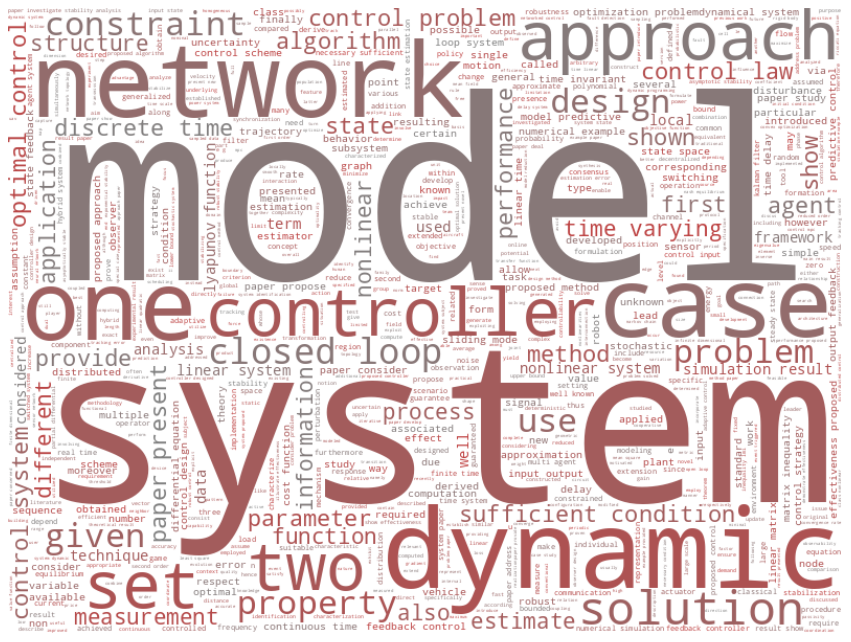

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.012*"method" + 0.010*"robot" + 0.010*"problem" + 0.008*"system" + 0.006*"approach" + 0.005*"set" + 0.005*"time"'),
 (1,
  '0.010*"target" + 0.004*"problem" + 0.004*"agent" + 0.004*"level set" + 0.003*"game" + 0.003*"camera" + 0.003*"guidance law"'),
 (2,
  '0.024*"model" + 0.017*"system" + 0.012*"control" + 0.009*"dynamic" + 0.006*"time" + 0.006*"method" + 0.006*"approach"'),
 (3,
  '0.008*"problem" + 0.007*"game" + 0.004*"potential game" + 0.004*"strategy" + 0.004*"system" + 0.004*"robot" + 0.003*"set"'),
 (4,
  '0.005*"control" + 0.004*"algorithm" + 0.003*"lie group" + 0.003*"problem" + 0.003*"approach" + 0.003*"nmpc" + 0.002*"method"'),
 (5,
  '0.017*"problem" + 0.010*"solution" + 0.009*"system" + 0.009*"constraint" + 0.009*"optimal control" + 0.007*"cost" + 0.006*"algorithm"'),
 (6,
  '0.040*"system" + 0.018*"control" + 0.015*"controller" + 0.012*"problem" + 0.010*"proposed" + 0.008*"design" + 0.007*"method"'),
 (7,
  '0.017*"control" + 0.014*"system" + 0.006*"network" + 

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

method     robot   problem    system  approach       set      time  \
0  0.011834  0.010207  0.010169  0.007728  0.005712  0.004579  0.004502   
1  0.000000  0.000000  0.004234  0.001941  0.000000  0.000000  0.000000   
2  0.005658  0.000000  0.004140  0.016773  0.005623  0.000000  0.005660   
3  0.002459  0.003611  0.007511  0.003659  0.000000  0.003290  0.000000   
4  0.002475  0.000000  0.003140  0.002089  0.003091  0.000000  0.000000   
5  0.004809  0.000000  0.017217  0.009455  0.000000  0.002980  0.006122   
6  0.007348  0.000000  0.011595  0.040404  0.007089  0.003602  0.000000   
7  0.002773  0.000000  0.004987  0.013582  0.003175  0.002449  0.000000   
8  0.003971  0.000000  0.012986  0.009902  0.000000  0.003358  0.003833   
9  0.001930  0.001751  0.003189  0.006964  0.002974  0.000000  0.000000   

   solution       one     point  ...    matrix  intruder  deferrable load  \
0  0.004433  0.004356  0.004303  ...  0.000000  0.000000         0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000         0.000000   
2  0.000000  0.002880  0.000000  ...  0.000000  0.000000         0.000000   
3  0.002662  0.002596  0.002193  ...  0.000000  0.000000         0.000000   
4  0.000000  0.001747  0.000000  ...  0.000000  0.000000         0.000000   
5  0.010121  0.003517  0.000000  ...  0.000000  0.000000         0.000000   
6  0.000000  0.000000  0.000000  ...  0.000000  0.000000         0.000000   
7  0.004147  0.000000  0.000000  ...  0.000000  0.000000         0.000000   
8  0.000000  0.000000  0.000000  ...  0.003459  0.000000         0.000000   
9  0.000000  0.000000  0.000000  ...  0.000000  0.003861         0.002584   

   compliance  potential function  learning     input       de  disturbance  \
0    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
1    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
2    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
3    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
4    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
5    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
6    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
7    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
8    0.000000            0.000000  0.000000  0.000000  0.00000     0.000000   
9    0.002135            0.002104  0.001981  0.001882  0.00187     0.001853   

   petri net  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.000000  
8   0.000000  
9   0.001847  

[10 rows x 119 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



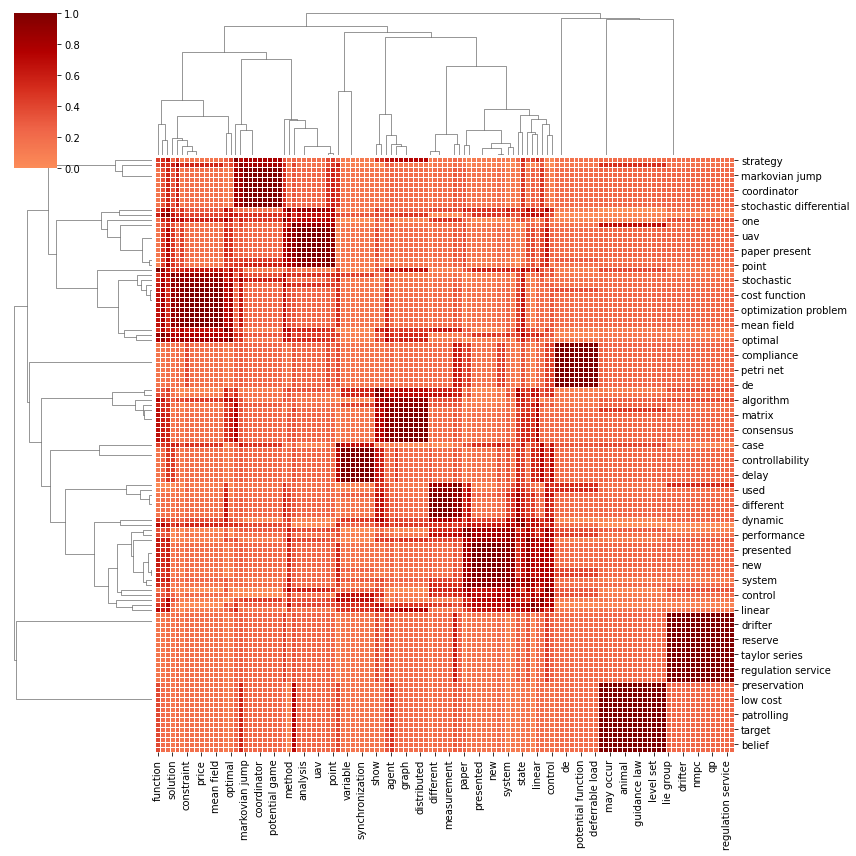

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  37.637690
6       0.648955  71.707100       2        1  18.699469
5      71.019684   9.971006       3        1   6.337974
7       3.785981  33.185135       4        1   5.635942
8     -42.666500  -9.222070       5        1   5.412682
1      -3.621689 -43.526516       6        1   5.284636
0      -3.632402  -4.171708       7        1   5.248518
9     -36.584400  35.804413       8        1   5.248147
3      44.391380  50.615383       9        1   5.247628
4      40.235809 -31.591665      10        1   5.247313, topic_info=              Term        Freq       Total Category  logprob  loglift
57          system  185.000000  185.000000  Default  30.0000  30.0000
99         problem   79.000000   79.000000  Default  29.0000  29.0000
215        network   31.000000   31.000000  Default  28.0000  28.0000
76         control  112.000000  112.000000  Default  27.0000  27.0000
327      algorithm   45.000000   45.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
57          system    1.200064  185.491282  Topic10  -6.1710  -2.0932
35             one    1.003330   28.449273  Topic10  -6.3500  -0.3973
175           time    1.002566   42.923446  Topic10  -6.3508  -0.8094
476          paper    0.935119   44.765084  Topic10  -6.4204  -0.9211
888  paper present    0.925542   18.183464  Topic10  -6.4307  -0.0304

[796 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
4868      10  0.747488               ac
4633       6  1.169409  adaptive filter
21494      8  1.452391   admissible set
15228     10  1.805428        aerospace
816        1  0.175561            agent
...      ...       ...              ...
2376       1  0.707011       wind speed
2377       1  0.867242     wind turbine
10067      9  1.623378     within given
5441       1  1.234032   work considers
8393       4  0.867551                x

[993 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 8, 9, 2, 1, 10, 4, 5])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  nuroa, cryptic viremia, cryptic, lempc, phage, mpc consensus, mpc consensus protocol, suboptimal event, suboptimal event trigger, polynomial suboptimal, polynomial suboptimal event, optimal adsorption, adsorption rate, phage survival, support cryptic

Paper Titles:
A compartment based model for the formation of 2-LTR circles after raltegravir intensification
NUROA: A numerical roadmap algorithm
A brief and some further insight on the Exact Quadratization of nonlinear control systems
Optimizing phage λ survival in a changing environment: Stochastic model predictions

****************************************************************************************************
TOPIC 1:
Top Words:  system, control, problem, time, model, controller, state, paper, method, algorithm, proposed, linear, network, result, condition

Paper Titles:
Cooperative and hierarchical fuzzy MPC for building heating control
Tracking control of direct-drive servos
Uniform and complex bids for dem

In [44]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [46]:
representative_df.to_csv("repr_21246.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
62714     1024010        21246             9475   
61834     1248921        21246             9475   
53310     3005665        21246             9475   
53385     2930582        21246             9475   
19135      861288        21246             8228   
...           ...          ...              ...   
53456     2948370        21246             9475   
53362     2978431        21246             9475   
53317     3005622        21246             9475   
53394     2930912        21246             9475   
59983     1702368        21246             9475   

                                                   title  year  \
62714  A compartment based model for the formation of...  2012   
61834               NUROA: A numerical roadmap algorithm  2014   
53310  A brief and some further insight on the Exact ...  2016   
53385  Optimizing phage λ survival in a changing envi...  2016   
19135  Weight based dominating set clustering algorit...  2012   
...                                                  ...   ...   
53456  Flatness of two-input control-affine systems l...  2016   
53362  On input-to-state-stability and integral input...  2016   
53317  Consensus by maximum hands-off distributed con...  2016   
53394  Diagonal Lyapunov functions for positive linea...  2016   
59983       Maximum hands-off control and L 1 optimality  2013   

                                                abstract  
62714  Highly Active Antiretroviral Therapy (HAART) c...  
61834  Motion planning has been studied for nearly fo...  
53310  This paper aims to be, first of all, a short s...  
53385  Bacteriophages - viruses that infect and repli...  
19135  Due to the size and density of small satellite...  
...                                                  ...  
53456  We study flatness of two-input control-affine ...  
53362  This work contributes to the recently intensif...  
53317  In this paper, we propose a distributed contro...  
53394  Stable positive linear time-invariant autonomo...  
59983  In this article, we propose a new paradigm of ...  

[909 rows x 6 columns]